## Transformer 学习

Transformer 是文章《Attention Is All You Need》提出的一个模型结构，是 NLP 领域非常有创新性的成果。基于 Transformer 构建的模型 Bert，更是在多个自然语言任务上都取得了革命性的效果，可见 Transformer 的厉害之处。

Transformer 的创新之处是完全摒弃了循环和卷积的思路，只用到了注意力机制。这一架构的主要优点是层输出可以并行计算，而非像 RNN 这样的序列计算，而且能学习长距离的依赖。

先看看 Transformer 的整体架构：
<img src="/images/model_architecture.png" width="700">
下面，一步步地剖析这个架构。

### 1. Positional encoding (位置编码)

由于 Transformer 不包括循环或卷积，所以为了标记单词在句子中的相对位置，模型使用了 positional encoding。positional encoding 被加到 word embedding 向量中作为最终的输入。加入位置编码后，每个词根据它们的语义相似度和在句子中的位置来决定它们的最终相似度。

文章使用的位置编码为：
<img src="/images/positional_encoding.png" width="480">

其中，$pos$ 表示位置，$i$ 表示维度。这样，positinal encoding 的每一维度都对应一个正弦曲线。为什么选择这个函数，作者认为这样可以让模型更容易地通过相对位置来学习。文章也尝试用学习好的位置编码，发现这两种方法效果差不多。

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import time
import matplotlib.pyplot as plt
tf.enable_eager_execution()

In [3]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2))/np.float32(d_model))
    return pos * angle_rates

In [4]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])  # 偶数 index 上用 sin 函数
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])  # 奇数 index 上用 cos 函数
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

In [5]:
pos_encoding = positional_encoding(100, 512)
print(pos_encoding.shape)

(1, 100, 512)


### 2. Masking

Masking 的作用是 mask 序列中的填充位，确保模型不会将填充位作为输入。mask 值表明了填充值 0 出现的位置，在这些位置 mask 输出 1，否则输出 0.

In [6]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [7]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: id=9, shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

look-ahead mask 用来 mask 序列中未来的 token。这意味着，为了预测第三个词，只能使用第一、二个词，为了预测第四个词，只能使用前三个词等。

In [8]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq, seq)

In [9]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: id=25, shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

### 3. Attention

Transformer 有两种 Attention：Scaled dot-product attention 和 Multi-head attention，其实 scaled dot-product attention 是 multi-head attention 的组成部分。
<img src="/images/transformer_attention.png" width=530>
Attention 的作用就是把 query、key-value对 映射到 output 中，它们都是向量。ouput 是 value 的加权和，权重通过 query 和对应的 key 计算得到。

**Scaled dot-product attention**

按比缩放点积注意力的输入为 queries、$d_k$ 维度的 keys 和 $d_v$ 维度的 values。先计算 query 和 keys 的乘积，除以 $\sqrt{d_k}$，然后求 softmax 操作得到 values 的权重。实际操作中，attention 操作是在一组 queries 上同时进行的，堆叠在一起形成矩阵 $Q$，keys 和 values 同样堆叠起来形成矩阵 $K$ 和 $V$。计算方式如下：
$$Attention(Q,K,V)=softmax(\frac{QK^T}{\sqrt{d_k}})V$$
这里除以 $\sqrt{d_k}$ 是因为当 $d_k$ 比较大时，点积也会变大，这样 softmax 出来后会得到很小的梯度，所以除以 $\sqrt{d_k}$ 来规避这种影响。

In [10]:
def scaled_dot_product_attention(q, k, v, mask):
    """
    这里 q, k, v 的维度要满足一定的条件：
    q, k, v 必须具有匹配的 leading dimensions
    k, v 要满足 seq_len_k == seq_len_v
    Args:
        q: query shape (..., seq_len_q, depth)
        k: key shape (..., seq_len_k, depth)
        v: value shape (..., seq_len_v, depth_v)
        mask: Float tensor，其维度要能转换为 (..., seq_len_q, seq_len_k)。默认为 None
    """
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # 对 k 进行转置，结果为 (..., seq_len_q, seq_len_k)
    
    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
    
    # 在最后一个轴上做 softmax
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)
    return output, attention_weights

output 代表 attention 权重和 value 的乘积，这能保证关注的词被保留，而无关的词被清除掉。

In [11]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(q, k, v, None)
    print('Attention weights are:', temp_attn)
    print('Output is:', temp_out)

In [12]:
np.set_printoptions(suppress=True)
temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)  # (4, 3)
temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32)  # (4, 2)
# 第一个 query [0, 10, 0] 符合第二个 key [0, 10, 0], 因此返回了第二个 value [10, 0]
# 第二个 query[0, 0, 10] 符合第三、四个 key [0, 0, 10]，因此返回 第三、四个 value 的平均值
# 第三个 query [10, 10, 0] 符合第一、二个 key [10, 0, 0] [0, 10, 0]，因此返回它们的平均值
temp_q = tf.constant([[0, 10, 0], [0, 0, 10], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are: tf.Tensor(
[[0.  1.  0.  0. ]
 [0.  0.  0.5 0.5]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is: tf.Tensor(
[[ 10.    0. ]
 [550.    5.5]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


**Multi-head attention**

多头注意力不是简单的执行 $d_{model}$ 维的 attention 操作，而是分别对 queries、keys 和 values 做了线性映射（这三个映射是不同的），分别映射到 $d_k$、$d_k$ 和 $d_v$ 维度。然后在每个映射版本上并行地执行 attention 操作，生成 $d_v$ 的输出值，然后将这些值拼接起来再进行一次线性映射得到最终结果（如上图所示），这么做的意义是模型可以注意来自不同表示空间的不同位置的信息。
<img src="/images/multihead_attention.png" width=450>

In [13]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads  # 8
        self.d_model = d_model  # 512
        
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads  # 64
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_head(self, x, batch_size):
        """
        先将最后一维分割为 (num_heads, depth),
        然后做 transpose，变为（batch_size, num_heads, seq_len, detph）
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))  # (batch_size, seq_len, num_heads, depth)
        return tf.transpose(x, perm=[0, 2, 1, 3])  # (batch_size, num_heads, seq_len, depth)
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)
        
        q = self.split_head(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_head(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_head(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
        
        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)
        
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)
        
        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
        return output, attention_weights

在序列的每个位置，MultiHeadAttention 在序列中的所有其它位置运行所有 8 个注意力头，在每个位置，返回一个新的同样长度的向量。

In [14]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
print(out.shape)
print(attn.shape)

(1, 60, 512)
(1, 8, 60, 60)


### 4. Position-wise Feed-forward networks

除了 attention 层，encoder 和 decoder 的每层还有全连接前向网络，包括两层线性变换，两层之间是 ReLU 激活函数。
$$FFN(x)=max(0, xW_1+b_1)W_2+b_2$$
线性变换在不同位置之间是相同的，层与层之间是不同的。

In [15]:
def point_wise_feed_forward_network(d_model, dff):  # dff: dimension of feed forward
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

In [16]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
print(sample_ffn(tf.random.uniform((64, 50, 512))).shape)

(64, 50, 512)


### 5. Encoder and decoder

Transformer 模型与标准的具有注意力机制的 seq2seq 模型，具有一样的模式：
* 输入语句经过 N 个 encoder 层，为序列中每个词生成一个输出；
* decoder 关注 encoder 的输出以及它自身的输入（自注意力）来预测下一个词。

**Encoder layer**

每个 encoder 层包含两个子层：
* Multi-head attention (with padding mask)
* Position-wise feed forward networks

两层之间用残差连接，然后后面是 layer normalization，残差连接可以避免梯度消失问题。Transformer 中有 N 个 encoder 层。

In [17]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
        
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
        
        return out2

In [18]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)
sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)
print(sample_encoder_layer_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 43, 512)


**Decoder layer**

每个 decoder 层有三个子层:
* Masked multi-head attention (with look ahead mask and padding mask)
* MultiheadAttention (with padding mask)，其中 V(value) 和 K(key) 以 encoder 的输出为输入，Q(query) 接受 masked multi-head attention 子层的输出。
* Position-wise feed forward networks

同 encoder 层一样，两子层之间是残差连接，后接一个 layer normalization。Transformer 有 N 个 decoder 层。

当 Q 接收到 decoder 第一个子层的输出，K 接收到 encoder 的输出时，attention weights 表示根据 encoder 的输出而赋予 decoder 的输入的重要程度。换句话说，decoder 根据 encoder 的输出和自身输出的自注意力来预测下一个词。

In [19]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # enc_out.shape == (batch_size, input_seq_len, d_model)
        
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)  # (batch_size, target_seq_len, d_model)
        
        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
        
        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
        
        return out3, attn_weights_block1, attn_weights_block2

In [20]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)
sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output,
    False, None, None)
print(sample_decoder_layer_output.shape)  # (batch_size, target_seq_len, d_model)，其中 sample_encoder_layer_output 为 (64, 43, 512)

(64, 50, 512)


**Encoder (编码器)**

Encoder 包括三个部分：
* Input embedding
* Positional encoding
* N encoder layers

输入首先经过 embedding，然后与 positional encoding 相加，相加的结果作为 encoder 的输入，encoder 的输出作为 decoder 的输入。

In [21]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)  # (1, maximum_position_encoding, d_model)
        
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                          for _ in range(num_layers)]
        
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]  # 第二维为序列长度
        
        # adding embedding and position encoding
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))  # 根据论文，embedding 的权重要乘以 sqrt(d_model)
        x += self.pos_encoding[:, :seq_len, :]  # (batch_size, seq_len, d_model)
        
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
            
        return x  # (batch_size, input_seq_len, d_model)

In [22]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
                        dff=2048, input_vocab_size=8500, maximum_position_encoding=10000)
sample_encoder_output = sample_encoder(tf.random.uniform((64, 62)), training=False, mask=None)
print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


**Decoder (解码器)**

decoder 也包括三个部分：
* Output embedding
* Positional encoding
* N decoder layers

目标（target）经过 word embedding 后，和位置编码相加。相加的结果作为解码器的输入，解码器的输出作为最后线性层的输入。

In [23]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
                maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                          for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        
        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
            
        # x.shape == (batch, target_seq_len, d_model)
        return x, attention_weights

In [24]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8,
                        dff=2048, target_vocab_size=8000, maximum_position_encoding=5000)
output, attn = sample_decoder(tf.random.uniform((64, 26)),
                             enc_output = sample_encoder_output,
                             training=False, look_ahead_mask=None, padding_mask=None)
print(output.shape)  # (batch_size, target_seq_len, d_model)
print(attn['decoder_layer2_block2'].shape)  # (batch_size, num_heads, seq_len_q, seq_len_k)

(64, 26, 512)
(64, 8, 26, 62)


### 6.创建 Transformer

Transformer 包括编码器、解码器和最后的线性层，解码器的输出是线性层的输入，返回线性层的输出。

In [25]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()
        
        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                              input_vocab_size, pe_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                              target_vocab_size, pe_target, rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)  # 最后的线性层，输出的维度为 target_vocab_size
        
    def call(self, inp, tar, training, enc_padding_mask,
            look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
        
        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)  # decoder 以 encoder 的输出作为输入
        
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
        
        return final_output, attention_weights

In [26]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048,
    input_vocab_size=8500, target_vocab_size=8000,
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 62))
temp_target = tf.random.uniform((64, 26))

fn_out, _ = sample_transformer(temp_input, temp_target, training=False,
                              enc_padding_mask=None,
                              look_ahead_mask=None,
                              dec_padding_mask=None)

print(fn_out.shape)  # (batch_size, tar_seq_len, target_vocab_size)

(64, 26, 8000)


**构建数据集**

Transformer 的整体架构已经介绍清楚，下面以具体的例子来将整个过程串起来。首先使用 TFDS 来下载数据集。

In [27]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                              as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

In [28]:
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en, in train_examples), target_vocab_size=2**13)

tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

In [29]:
sample_string = 'Transformer is awesome.'

tokenized_string = tokenizer_en.encode(sample_string)
print('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_en.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7877]
The original string: Transformer is awesome.


如果某个词没在词典中出现过，tokenizer 会将其分割成 subwords 然后再编码。

In [30]:
for ts in tokenized_string:
    print('{} ---> {}'.format(ts, tokenizer_en.decode([ts])))

7915 ---> T
1248 ---> ran
7946 ---> s
7194 ---> former 
13 ---> is 
2799 ---> awesome
7877 ---> .


In [31]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [32]:
def encode(lang1, lang2):
    """
    Add a start and end token to the input and target.
    """
    lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
        lang1.numpy()) + [tokenizer_pt.vocab_size + 1]
    
    lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
        lang2.numpy()) + [tokenizer_en.vocab_size + 1]
    
    return lang1, lang2

为了使模型小巧训练快，去掉长度大于40的句子。

In [33]:
MAX_LENGTH = 40

In [34]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
    return tf.logical_and(tf.size(x) <= max_length,
                         tf.size(y) <= max_length)

In [35]:
def tf_encode(pt, en):
    return tf.py_function(encode, [pt, en], [tf.int64, tf.int64])

In [36]:
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
# Cache the dataset to memory to get a speedup while reading from it
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(
    BATCH_SIZE, padded_shapes=([-1], [-1]))
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(
    BATCH_SIZE, padded_shapes=([-1], [-1]))

In [38]:
pt_batch, en_batch = next(iter(val_dataset))
pt_batch, en_batch

(<tf.Tensor: id=316814, shape=(64, 40), dtype=int64, numpy=
 array([[8214, 1259,    5, ...,    0,    0,    0],
        [8214,  299,   13, ...,    0,    0,    0],
        [8214,   59,    8, ...,    0,    0,    0],
        ...,
        [8214,   95,    3, ...,    0,    0,    0],
        [8214, 5157,    1, ...,    0,    0,    0],
        [8214, 4479, 7990, ...,    0,    0,    0]])>,
 <tf.Tensor: id=316815, shape=(64, 40), dtype=int64, numpy=
 array([[8087,   18,   12, ...,    0,    0,    0],
        [8087,  634,   30, ...,    0,    0,    0],
        [8087,   16,   13, ...,    0,    0,    0],
        ...,
        [8087,   12,   20, ...,    0,    0,    0],
        [8087,   17, 4981, ...,    0,    0,    0],
        [8087,   12, 5453, ...,    0,    0,    0]])>)

**配置超参数（hyperparameters）**

Transformer 的基础模型使用的数值为：num_layers=6, d_model=512, dff=2048。在本示例中，为了让模型训练速度加快，使用如下较小的值。

Note: 通过改变一下的数值，可以获得在许多任务上达到最先进水平的模型。

In [39]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2  # 加了 SOS、EOS
target_vocab_size = tokenizer_en.vocab_size + 2  # 加了 SOS、EOS

dropout_rate = 0.1

In [40]:
input_vocab_size, target_vocab_size

(8216, 8089)

**优化器（Optimizer）**

论文使用 Adam 优化器：$\beta_1=0.9, \beta_2=0.98, \epsilon=10^{-9}$，并且使用可变学习率：
$$lrate=d^{-0.5}_{model}\cdot min(step\_num^{-0.5}, step\_num\cdot warmup\_steps^{-1.5})$$
学习率在第一个 *warmup_steps* 训练轮内线性增长，然后减小。论文中使用 $warmup_steps=4000$。

In [41]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)
        
        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)  # rsqrt() 表示求平方根的倒数
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [42]:
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Text(0.5, 0, 'Train step')

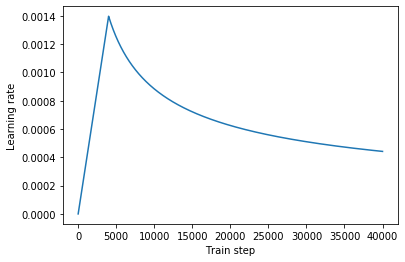

In [43]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)).numpy())
plt.ylabel('Learning rate')
plt.xlabel('Train step')

**损失函数与指标（Loss and metrics）**

由于目标序列是填充（padded）过的，因此在计算损失时应使用 padding mask。

In [44]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [45]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

In [46]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

**Training and checkpointing**

In [47]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                        input_vocab_size, target_vocab_size,
                        pe_input=input_vocab_size,
                        pe_target=target_vocab_size,
                        rate=dropout_rate)

In [48]:
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)
    
    # Used in the 2nd attention block in the decoder
    # This padding mask is used to mask the encoder outputs
    dec_padding_mask = create_padding_mask(inp)
    
    # Used in the 1st attention block in the decoder
    # It is used to pad and mask future tokens in the input received by the decoder
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])  # size 为 target_seq_len
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    
    return enc_padding_mask, combined_mask, dec_padding_mask

In [49]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                          optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the lastest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!')

Latest checkpoint restored!


将 target 分成 tar_input 和 tar_real。tar_input 作为 decoder 的输入，tar_real 是一样的输入，只是位置左移一位。在 tar_input 的每一位置，tar_real 对应应该被预测的下一个 token。

例如，sentence = 'SOS A lion in the jungle is sleeping EOS'
```
tar_input = 'SOS A lion in the jungle is sleeping'
tar_real = 'A lion in the jugle is sleeping EOS'
```

Transformer 是 auto-regressive 模型，它一次预测一部分，然后以当前输出来决定下一步要做什么。在训练过程中，本示例使用了 teacher-forcing 方法，无论模型在当前时刻预测出什么，teacher-forcing 方法都会将真实的输出传递到下一个时间步骤上。

Transformer 预测每个词的时候，self-attention 可以查看输入序列的前面的词，来更好地预测下一个词。为了防止 decoder 偷看答案，要使用 look-ahead mask。

In [50]:
EPOCHS = 20

In [51]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]  # EOS 之前的词
    tar_real = tar[:, 1:]  # SOS 之后的词
    
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp,
                                    True,
                                    enc_padding_mask,
                                    combined_mask,
                                    dec_padding_mask)
        loss = loss_function(tar_real, predictions)
    
    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    
    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [ ]:
for epoch in range(EPOCHS):
    start = time.time()
    
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    # inp -> portuguese, tar -> english
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)
        
        if batch % 50 == 0:
            print('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
                epoch + 1, batch, train_loss.result(), train_accuracy.result()))
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
    
    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,
                                                         train_loss.result(),train_accuracy.result()))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

### 7. Evaluate

Evaluate 阶段有以下步骤：
* 使用 tokenizer_pt 将输入序列编码，并加上 start 和 end token（和模型训练时一样）。这是 encoder 输入；
* decoder 输入为 start token == tokenizer_en.vocab_size;
* 计算 padding mask 和 look ahead mask。
* decoder 通过查看 encoder 输出和它自身输出（自注意力）来预测结果；
* 选择最后一个词，计算它的 argmax;
* 将预测的词拼接到 decoder 输入，然后传递给 decoder;
* 在这种方法中，decoder 根据它预测的之前一个词来预测下一个。

In [52]:
def evaluate(inp_sentence):
    start_token = [tokenizer_pt.vocab_size]
    end_token = [tokenizer_pt.vocab_size + 1]
    
    # 输入语句是葡萄牙语，增加开始和结束标记
    inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
    encoder_input = tf.expand_dims(inp_sentence, 0)  # 维度变为 (1, inp_sentence.shape)
    
    # 目标是英语，输入 transformer 的第一个词应该是英语的开始标记
    decoder_input = [tokenizer_en.vocab_size]
    output = tf.expand_dims(decoder_input, 0)  # 维度是（1, 1）
    
    for i in range(MAX_LENGTH):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)
        
        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input,
                                                     output,
                                                     False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)
        
        # 从 seq_len 维度选择最后一个词
        predictions = predictions[:, -1:, :]  # (1, 1, vocab_size)
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)  # (1, 1)
        
        # 如果 predicted_id 等于结束标记，就返回结果
        if predicted_id == tokenizer_en.vocab_size + 1:
            return tf.squeeze(output, axis=0), attention_weights
        
        # 将 predicted_id 与输出，作为 decoder 的输入传递到 decoder
        output = tf.concat([output, predicted_id], axis=-1)  # (1, output.shape[-1] + 1)
    
    # 返回的 squeeze 后的 output 维度为 [output.shape[1]]
    return tf.squeeze(output, axis=0), attention_weights        

In [53]:
def plot_attention_weights(attention, sentence, result, layer):
    fig = plt.figure(figsize=(16, 8))
  
    sentence = tokenizer_pt.encode(sentence)
  
    attention = tf.squeeze(attention[layer], axis=0)
  
    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head+1)
    
        # 画出注意力权重
        ax.matshow(attention[head][:-1, :], cmap='viridis')

        fontdict = {'fontsize': 10}
    
        ax.set_xticks(range(len(sentence)+2))
        ax.set_yticks(range(len(result)))
    
        ax.set_ylim(len(result)-1.5, -0.5)
        
        ax.set_xticklabels(
            ['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'], 
            fontdict=fontdict, rotation=90)
    
        ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
                            if i < tokenizer_en.vocab_size], 
                           fontdict=fontdict)
    
        ax.set_xlabel('Head {}'.format(head+1))
  
    plt.tight_layout()
    plt.show()

In [54]:
def translate(sentence, plot=''):
    result, attention_weights = evaluate(sentence)
    
    predicted_sentence = tokenizer_en.decode([i for i in result if i < tokenizer_en.vocab_size])
    
    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentence))

In [55]:
translate("este é um problema que temos que resolver.")
print ("Real translation: this is a problem we have to solve .")

Input: este é um problema que temos que resolver.
Predicted translation: this is a problem that we have to solve the u.s . . .s . here .this this this this is this this this this 
Real translation: this is a problem we have to solve .


In [56]:
translate("os meus vizinhos ouviram sobre esta ideia.")
print ("Real translation: and my neighboring homes heard about this idea .")

Input: os meus vizinhos ouviram sobre esta ideia.
Predicted translation: my parents heard about this idea . . .ssssmy my my my my my my my my my 
Real translation: and my neighboring homes heard about this idea .


In [57]:
translate("este é o primeiro livro que eu fiz.", plot='decoder_layer4_block2')
print ("Real translation: this is the first book i've ever done.")

Input: este é o primeiro livro que eu fiz.
Predicted translation: this is the first book that i did n't know what i was . . . is .this is this this this this this this this here . ''
Real translation: this is the first book i've ever done.
